In [47]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB


# Benchmark models

### Benchmark model : Bag of words

In [35]:
#Import the dataset
data_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/archive/all-data.csv'
df = pd.read_csv(data_path, 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

In [36]:
df = df.rename(columns={'Text' : 'text' , 'Sentiment' : 'sentiment'})

In [16]:
df["text"]=df["text"].str.lower() #We convert our texts to lowercase.
df["text"]=df["text"].str.replace("[^\w\s]","") #We remove punctuation marks from our texts.
df["text"]=df["text"].str.replace("\d+","") #We are removing numbers from our texts.
df["text"]=df["text"].str.replace("\n","").replace("\r","") #We remove spaces in our texts.

In [21]:
# Splitting the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text data into a bag-of-words model
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train_bow)
X_test_counts = vectorizer.transform(X_test_bow)

# Training a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_counts, y_train_bow)

# Predicting and evaluating the model
y_pred_bow = clf.predict(X_test_counts)

# Calculate the performance metrics for each model
metrics_bow = {
    'accuracy': accuracy_score(y_test_bow, y_pred_bow),
    'precision': precision_score(y_test_bow, y_pred_bow, average='weighted'),
    'recall': recall_score(y_test_bow, y_pred_bow, average='weighted'),
    'f1': f1_score(y_test_bow, y_pred_bow, average='weighted')
}

### Benchmark model : TF-IDF (Term Frequency-Inverse Frequency)

In [22]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)

# Only transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = clf.predict(X_test_tfidf)

metrics_tfidf = {
    'accuracy': accuracy_score(y_test_tfidf, y_pred_tfidf),
    'precision': precision_score(y_test_tfidf, y_pred_tfidf, average='weighted'),
    'recall': recall_score(y_test_tfidf, y_pred_tfidf, average='weighted'),
    'f1': f1_score(y_test_tfidf, y_pred_tfidf, average='weighted')
}

### Benchmark model : GloVe

In [39]:
def load_glove_model(glove_file_path):
    print("Loading Glove Model")
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        glove_model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
        print(f"{len(glove_model)} words loaded!")
        return glove_model

glove_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/glove.6B/glove.6B.300d.txt'  # replace with your file path
glove_model = load_glove_model(glove_path)

X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

Loading Glove Model
400000 words loaded!


In [42]:
def document_vector(glove_model, doc):
    words = doc.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)  # 300 is the GloVe vector size


X_train_vectors = np.array([document_vector(glove_model, text) for text in X_train_glove])
X_test_vectors = np.array([document_vector(glove_model, text) for text in X_test_glove])

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectors, y_train_glove)

# Evaluate the model
y_pred_glove= model.predict(X_test_vectors)
print(classification_report(y_test_glove, y_pred_glove))

metrics_glove = {
    'accuracy': accuracy_score(y_test_glove, y_pred_glove),
    'precision': precision_score(y_test_glove, y_pred_glove, average='weighted'),
    'recall': recall_score(y_test_glove, y_pred_glove, average='weighted'),
    'f1': f1_score(y_test_glove, y_pred_glove, average='weighted')
}

              precision    recall  f1-score   support

    negative       0.75      0.49      0.59       110
     neutral       0.78      0.89      0.83       571
    positive       0.70      0.60      0.64       289

    accuracy                           0.76       970
   macro avg       0.74      0.66      0.69       970
weighted avg       0.75      0.76      0.75       970



### Financial BERT

In [46]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [48]:
X = df['text'].to_list()
y = df['sentiment'].to_list()

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [50]:
classification_report_finbert = classification_report(y, preds)

# Models comparaison

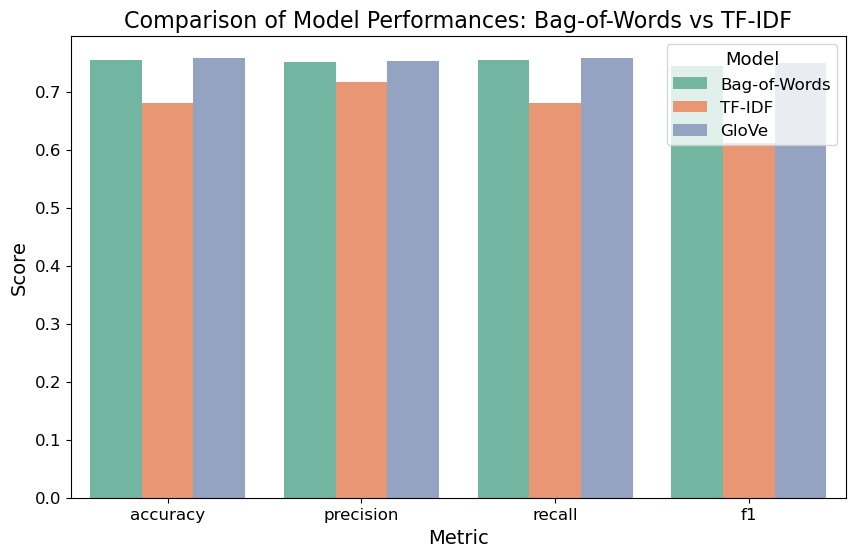

In [45]:
# Prepare DataFrame for Seaborn
data = []
for metric in metrics_bow.keys():
    data.append({'Model': 'Bag-of-Words', 'Metric': metric, 'Score': metrics_bow[metric]})
    data.append({'Model': 'TF-IDF', 'Metric': metric, 'Score': metrics_tfidf[metric]})
    data.append({'Model': 'GloVe', 'Metric': metric, 'Score': metrics_glove[metric]})
    data.append({'Model': 'FinBERT', 'Metric': metric, 'Score': metrics_glove[metric]})


metrics = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics , palette= 'Set2')

# Add labels and title
plt.title('Comparison of Model Performances: Bag-of-Words vs TF-IDF', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', title_fontsize='13', fontsize='12')

# Show the plot
plt.show()


# FINBERT

In [2]:
news_df = pd.read_csv('data/news_cleaned.csv')

In [4]:
#Keep only the news related to microsoft
msft_news_df = news_df[news_df.company == 'MSFT']
msft_news_df['article_tokens'] = msft_news_df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

In [5]:
#Keep only the article that have less than 512 tokens
df = msft_news_df.copy()
df = df[df.article_tokens < 350]
df = df.sample(1)

ValueError: a must be greater than 0 unless no samples are taken

In [25]:
df.text.values

array(['   Microsoft Corp.\'s chief executive is promising to boost employee compensation amid continued low unemployment across the U.S. and high inflation.    Satya Nadella told Microsoft employees Monday that the software maker plans to nearly double its global budget for merit-based salary raises, a person familiar with the announcement said. Mr. Nadella also said the company would increase annual stock compensation at least 25%, the person said.    Microsoft\'s readiness to spend more on staff follows similar moves by rivals in its core cloud-computing sector. Late last year, Alphabet Inc.\'s Google announced a new cash bonus plan that lets employees receive bonuses of nearly any size for nearly any reason. In February, Amazon.com Inc. said it would double its cash-pay cap for employees.    Microsoft has also seen competition for talent elsewhere. Its augmented reality HoloLens team has experienced a large number of employees being poached by Facebook owner Meta Platforms Inc.    

In [33]:
task_prefix = "Classify the sentiment of this text as positive, negative, or neutral: "
# use different length sentences to test batching
inputs = tokenizer([task_prefix + article for article in df.text.values], return_tensors="pt", padding=True)

output_sequences = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    do_sample=False,  # disable sampling to test if batching affects output
)

print(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))

[',, being poached by Facebook owner Meta Platforms Inc. Meta and']


In [3]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert" , output_attentions=True)

In [4]:
#Test summarization on few apple news and keep news that are less than 512 tokens
AAPL_news_df = news_df[news_df['company'] == 'MSFT']
AAPL_news_df = AAPL_news_df[AAPL_news_df['text'].apply(lambda x: len(tokenizer.tokenize(x)) < 512)]

Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors


In [5]:
AAPL_sample = AAPL_news_df.sample(50)
articles  = AAPL_sample.text.values.tolist()

In [6]:
inputs = tokenizer(articles, padding = True, truncation = True, return_tensors='pt')
outputs = model(**inputs, output_hidden_states=True)
print(outputs.logits.shape)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)


import pandas as pd


positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()


table = {'Headline':articles,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
      
df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])


df.head(5)

torch.Size([50, 3])
tensor([[0.0191, 0.8053, 0.1756],
        [0.0233, 0.7819, 0.1948],
        [0.0073, 0.9660, 0.0267],
        [0.0567, 0.0219, 0.9214],
        [0.0112, 0.9602, 0.0286],
        [0.2321, 0.0147, 0.7532],
        [0.0393, 0.0428, 0.9179],
        [0.0424, 0.3373, 0.6203],
        [0.0734, 0.0197, 0.9069],
        [0.0396, 0.0228, 0.9376],
        [0.0145, 0.9487, 0.0368],
        [0.0101, 0.9727, 0.0172],
        [0.0191, 0.9572, 0.0237],
        [0.0851, 0.2310, 0.6839],
        [0.5005, 0.4339, 0.0656],
        [0.0903, 0.1102, 0.7996],
        [0.0383, 0.0403, 0.9214],
        [0.1059, 0.0539, 0.8401],
        [0.0075, 0.9632, 0.0293],
        [0.4313, 0.0285, 0.5402],
        [0.1340, 0.0181, 0.8479],
        [0.2448, 0.5369, 0.2183],
        [0.2010, 0.0119, 0.7871],
        [0.1464, 0.0189, 0.8347],
        [0.0330, 0.4900, 0.4770],
        [0.2108, 0.0118, 0.7774],
        [0.4088, 0.1819, 0.4093],
        [0.7643, 0.0073, 0.2284],
        [0.0362, 0.4547, 0.5

,Headline,Positive,Negative,Neutral
0,Some companies declined to participate. They i...,0.019118,0.805273,0.175609
1,BNY Investment Adviserneither admitted nor den...,0.023341,0.781879,0.194781
2,"Another videogaming company, Niantic Inc., sai...",0.007295,0.966018,0.026687
3,Well-meaning Bill Gates falls into the zero em...,0.056712,0.021899,0.921388
4,"Parent company Alphabet reported 163,906 emplo...",0.011186,0.960237,0.028577


In [7]:
embeddings = outputs.hidden_states[-1]
embeddings.shape


torch.Size([50, 501, 768])

In [8]:
flattened_embeddings = embeddings.mean(dim=1)
flattened_embeddings_numpy = flattened_embeddings.detach().numpy()
flattened_embeddings_numpy.shape

(50, 768)

In [14]:
#run pca on the embeddings to reduce the dimensions to 5
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(flattened_embeddings_numpy)
principalComponents.shape

(50, 5)

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(flattened_embeddings_numpy)
df['Cluster'] = kmeans.labels_


/Users/romainberquet/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


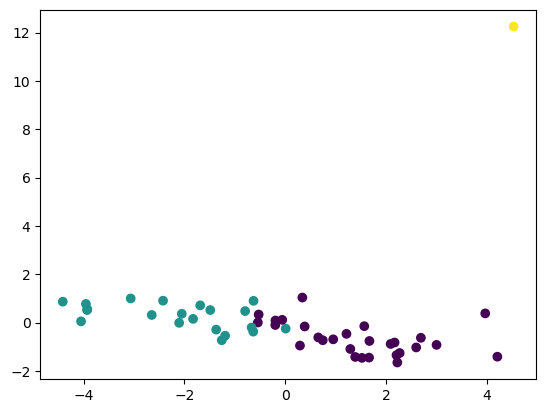

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.show()


/var/folders/d9/q7rftjxx3pd2mksp5nhnv4b80000gn/T/ipykernel_15170/1100720748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  APPL_sample_df['published'] = pd.to_datetime(APPL_sample_df['published'])


[*********************100%%**********************]  1 of 1 completed


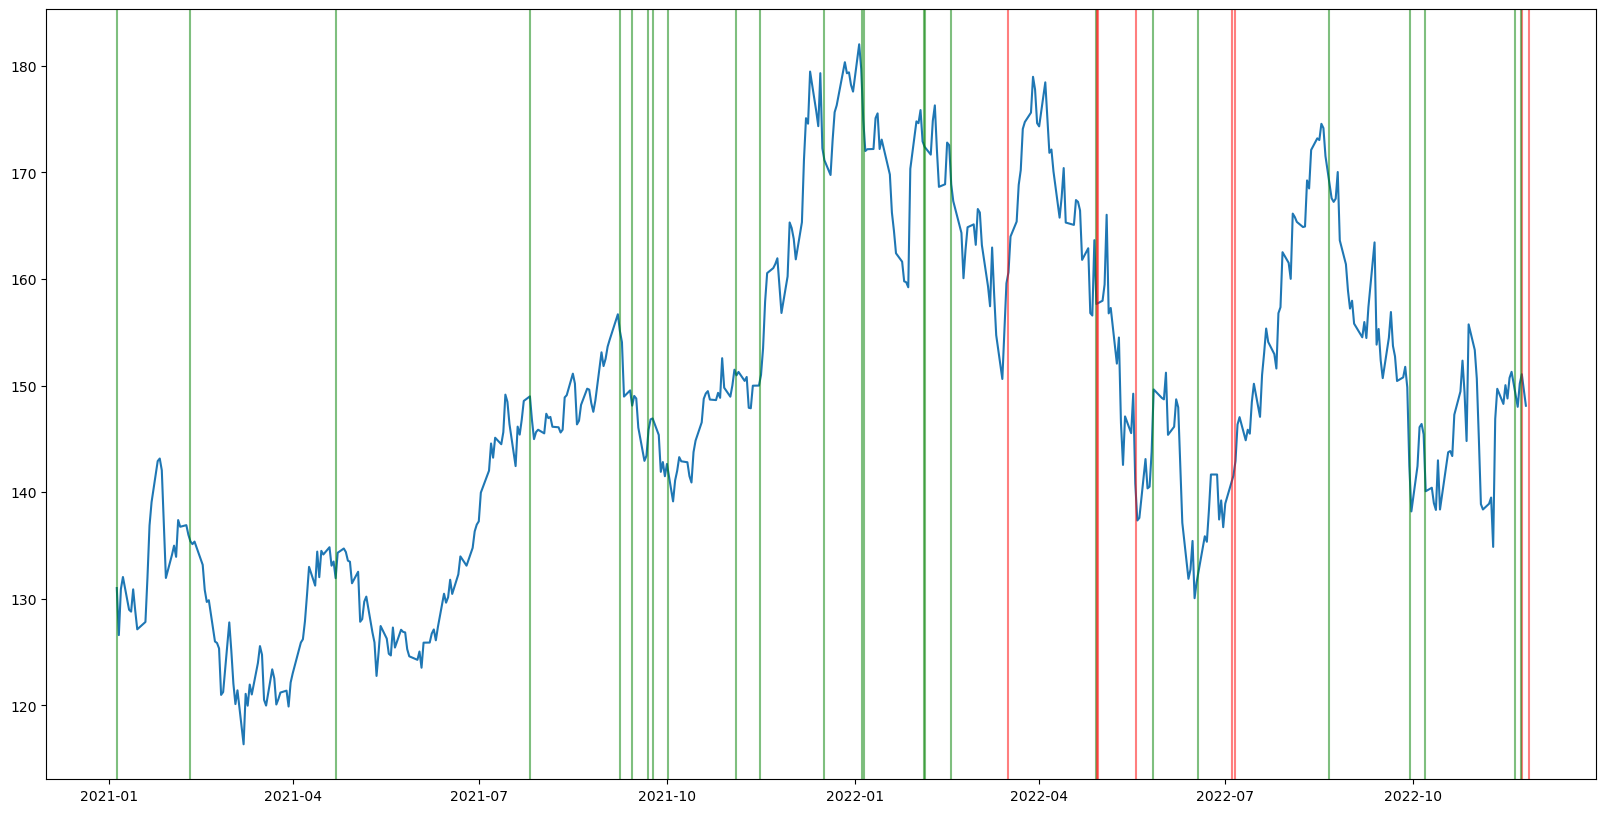

In [26]:
APPL_sample_df['published'] = pd.to_datetime(APPL_sample_df['published'])
#get the first date and last date of published news
min_published = APPL_sample_df['published'].min()
max_published = APPL_sample_df['published'].max()


#import apple stock data from yahoo finance and filter to keep only data between min and max published date
import yfinance as yf
import seaborn as sns
AAPL_stock_df = yf.download('AAPL', start=min_published, end=max_published, progress=True)
AAPL_stock_df.reset_index(inplace=True)


#Put on the stocks plot a vertical line for each news published date, green for positive news and red for negative news
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(AAPL_stock_df['Date'], AAPL_stock_df['Close'])
for index, row in APPL_sample_df.iterrows():
    if row['sentiment'] == 'negative':
        ax.axvline(row['published'], color='red', alpha=0.5)
    else:
        ax.axvline(row['published'], color='green', alpha=0.5)

,Open,High,Low,Close,Adj Close,Volume,strategy
Date,,,,,,,
2021-02-05,137.350006,137.419998,135.860001,136.759995,134.764709,75693800,1145.470001
2021-02-08,136.029999,136.960007,134.919998,136.910004,134.912552,71297200,1145.470001
2021-02-09,136.619995,137.880005,135.850006,136.009995,134.025696,76774200,1145.470001
2021-02-10,136.479996,136.990005,134.399994,135.389999,133.414719,73046600,1145.470001
2021-02-11,135.899994,136.389999,133.770004,135.130005,133.158524,64280000,1145.470001
...,...,...,...,...,...,...,...
2022-12-07,142.190002,143.369995,140.000000,140.940002,140.341248,69721100,6818.800049
2022-12-08,142.360001,143.520004,141.100006,142.649994,142.043976,62128300,6818.800049
2022-12-09,142.339996,145.570007,140.899994,142.160004,141.556076,76097000,6818.800049


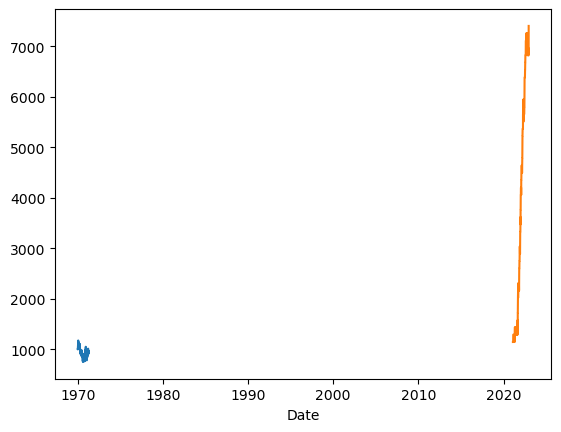

In [206]:
#Let follow a simple trading strategy, start wtih 1000$ and buy 1 stock when we have a positive news and sell 1 stock when we have a negative news
#We will compare this strategy with a buy and hold strategy
#Buy and hold strategy
buy_and_hold_df = AAPL_stock_df.copy()
buy_and_hold_df['buy_and_hold'] = buy_and_hold_df['Close'].apply(lambda x: 1000/x)
buy_and_hold_df['buy_and_hold'] = buy_and_hold_df['buy_and_hold'] * buy_and_hold_df['Close'].iloc[0]
buy_and_hold_df['buy_and_hold'].plot()




#Trading strategy, if the date in the stock data do not match the date in the news data, we will use the last date, test
APPL_stock_df = AAPL_stock_df.copy()

APPL_stock_df['Date'] = APPL_stock_df['Date'].dt.date
APPL_stock_df.set_index('Date', inplace=True)
APPL_stock_df['strategy'] = 0
APPL_stock_df['strategy'] = APPL_stock_df['strategy'].astype(float)
for index, row in APPL_sample_df.iterrows():
    if row['sentiment'] == 'negative':
        #if the published date is not in the stock data, we will use the last date
        if row['published'] not in APPL_stock_df.index:
            APPL_stock_df.loc[APPL_stock_df.index[-1], 'strategy'] -= 1
        else:
            APPL_stock_df.loc[row['published'], 'strategy'] -= 1
    else:
        #if the published date is not in the stock data, we will use the last date
        if row['published'] not in APPL_stock_df.index:
            APPL_stock_df.loc[APPL_stock_df.index[-1], 'strategy'] += 1
        else:
            APPL_stock_df.loc[row['published'], 'strategy'] += 1

APPL_stock_df['strategy'] = APPL_stock_df['strategy'].cumsum()
APPL_stock_df['strategy'] = APPL_stock_df['strategy'].apply(lambda x: 1000 + x*APPL_stock_df['Close'].iloc[-1])
APPL_stock_df['strategy'].plot()
        
APPL_stock_df

In [188]:
AAPL_stock_df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-05,137.350006,137.419998,135.860001,136.759995,134.764725,75693800
2021-02-08,136.029999,136.960007,134.919998,136.910004,134.912552,71297200
2021-02-09,136.619995,137.880005,135.850006,136.009995,134.025665,76774200
2021-02-10,136.479996,136.990005,134.399994,135.389999,133.414703,73046600
2021-02-11,135.899994,136.389999,133.770004,135.130005,133.158508,64280000
...,...,...,...,...,...,...
2022-12-07,142.190002,143.369995,140.000000,140.940002,140.341248,69721100
2022-12-08,142.360001,143.520004,141.100006,142.649994,142.043976,62128300
2022-12-09,142.339996,145.570007,140.899994,142.160004,141.556061,76097000


In [8]:
data

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
